# Facial Keypoint Detection
[참고 | Facial Keypoint Detection](https://www.kaggle.com/code/karanjakhar/facial-keypoint-detection)

- 3개의 CSV 파일
  - `training.csv` : 얼굴 부위의 키포인트 좌표
  - `test.csv` : `IdLookupTable.csv`의 3번째 데이터를 이용해, 좌표를 구해야하는 정보

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from IPython.display import clear_output
import time
import os
import pandas as pd

## Data Load

In [2]:
Train_Dir = "./FKD/training/training.csv"
Test_Dir = "./FKD/test/test.csv"
lookid_dir = "./FKD/IdLookupTable.csv"

train_data = pd.read_csv(Train_Dir)
test_data = pd.read_csv(Test_Dir)
lookid_data = pd.read_csv(lookid_dir)

print(f"Train: {train_data.shape}\nTest: {test_data.shape}\nlookid: {lookid_data.shape}")

Train: (7049, 31)
Test: (1783, 2)
lookid: (27124, 4)


## EDA

In [3]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


전치해서 샘플을 보는 방법이 신박..

### 결측치

In [4]:
train_data.isnull().any().value_counts()

True     28
False     3
dtype: int64

28개의 컬럼에 결측치가 존재  

In [5]:
# 이전 행의 데이터를 이용해 결측치를 채움
train_data = train_data.fillna(method="ffill")

In [6]:
train_data.isnull().any().value_counts()

False    31
dtype: int64

## Train Test Split

In [7]:
image = []
for idx in range(train_data.shape[0]):
    img = train_data["Image"][idx].split((" "))
    img = ["0" if x==" " else x for x in img]
    image.append(img)

In [8]:
image_list = np.array(image, dtype="float")
X_train = image_list.reshape(-1, 96, 96, 1)


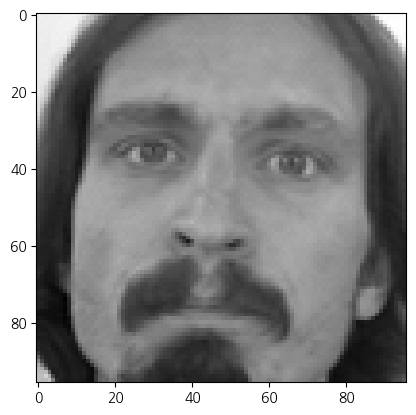

In [9]:
plt.imshow(X_train[0].reshape(96, 96), cmap="gray")
plt.show()

In [10]:
training = train_data.drop("Image", axis=1)

y_train = []
for idx in range(train_data.shape[0]):
    y = training.iloc[idx]
    y_train.append(y)

y_train = np.array(y_train, dtype="float")

In [11]:
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}")

X_train: (7049, 96, 96, 1)
y_train: (7049, 30)


## Modeling


In [12]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [13]:
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
# model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))

In [14]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [15]:
model.fit(X_train,y_train,epochs = 50,batch_size = 256,validation_split = 0.2)

Epoch 1/50
23/23 [==============================] - 13s 141ms/step - loss: 398.8206 - mae: 13.0062 - val_loss: 265.3918 - val_mae: 14.6498
Epoch 2/50
23/23 [==============================] - 3s 127ms/step - loss: 35.7163 - mae: 4.6563 - val_loss: 95.3521 - val_mae: 8.5286
Epoch 3/50
23/23 [==============================] - 3s 147ms/step - loss: 28.3026 - mae: 4.1224 - val_loss: 121.8393 - val_mae: 10.0869
Epoch 4/50
23/23 [==============================] - 4s 177ms/step - loss: 25.4401 - mae: 3.8901 - val_loss: 95.7800 - val_mae: 8.9338
Epoch 5/50
23/23 [==============================] - 4s 173ms/step - loss: 23.3590 - mae: 3.7186 - val_loss: 70.0791 - val_mae: 7.5457
Epoch 6/50
23/23 [==============================] - 4s 162ms/step - loss: 21.7641 - mae: 3.5758 - val_loss: 56.8209 - val_mae: 6.7960
Epoch 7/50
23/23 [==============================] - 4s 156ms/step - loss: 20.0267 - mae: 3.4213 - val_loss: 30.9227 - val_mae: 4.8413
Epoch 8/50
23/23 [==============================] - 4s 

## Test (Predict)

In [16]:
timag = []
for i in range(0,1783):
    timg = test_data['Image'][i].split(' ')
    timg = ['0' if x == '' else x for x in timg]
    
    timag.append(timg)

In [17]:
timage_list = np.array(timag,dtype = 'float')
X_test = timage_list.reshape(-1,96,96,1) 

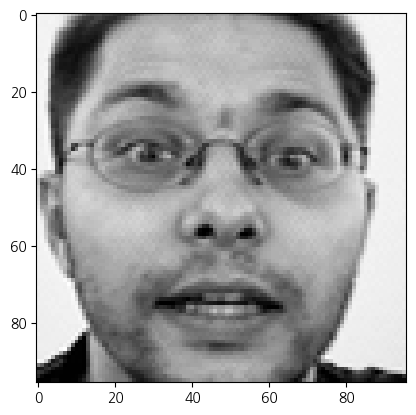

In [18]:
plt.imshow(X_test[0].reshape(96,96),cmap = 'gray')
plt.show()

In [19]:
pred = model.predict(X_test)

## Submit

In [20]:
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pre_list = list(pred)

In [21]:
rowid = lookid_data['RowId']
rowid=list(rowid)

In [22]:
feature = []
for f in list(lookid_data['FeatureName']):
    feature.append(lookid_list.index(f))

In [23]:
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])

In [24]:
rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(preded,name = 'Location')
submission = pd.concat([rowid,loc],axis = 1)
submission.to_csv('face_key_detection_submission.csv',index = False)